## Basic Setup

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler


csv_file_path = 'clean_merged_playerdata_with_weather.csv'

df = pd.read_csv(csv_file_path)



C:\Users\Olive\AppData\Local\Temp\ipykernel_10464\4238364773.py:17: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


## Cleaning

In [57]:
df = df.drop(["tie_rule", "bet_type", "open_time", "close_time", "book"], axis=1)




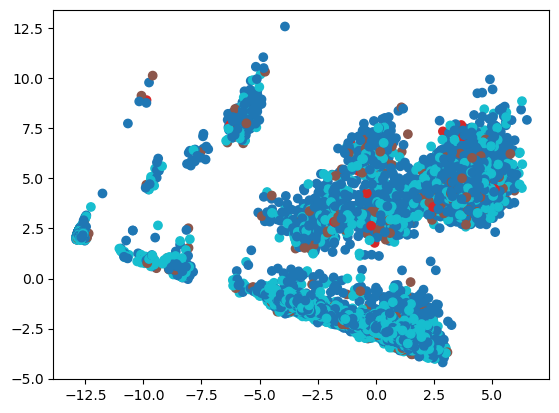

Var:  [0.2311853  0.12470554 0.04719005 0.04226641 0.03878139 0.03736653
 0.03668572 0.0196474  0.01713842 0.01669419]


In [66]:
df_copy = df.copy()
df_copy = df_copy.drop(["p1_outcome", "p2_outcome", "p3_outcome", 
                        "p1_player_name", "p2_player_name", "p3_player_name", 
                        "p1_outcome_text", "p2_outcome_text", "p3_outcome_text", 
                        "event_completed", "event_name", "wx_conditions", "wx_icon",
                        "wx_datetime_hour", "odds", "tour_p1"], axis=1)

pd.set_option("display.max_columns", None)

df_copy = df_copy.select_dtypes(include=['number'])
df_copy = df_copy.fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_copy)

pca = PCA(n_components=10)
transformed_data = pca.fit_transform(X_scaled)

plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=df["p1_outcome"], cmap="tab10")
plt.show()

print("Var: ", pca.explained_variance_ratio_)

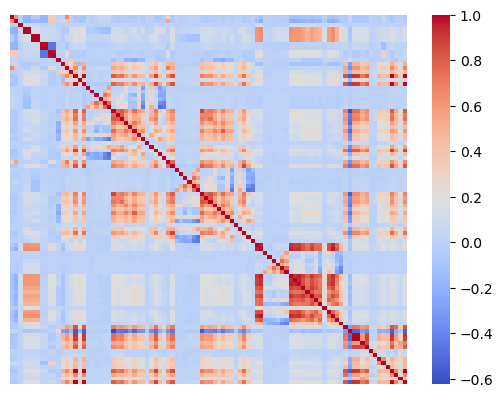

In [73]:
cor = df_copy.corr()
import seaborn as sns

sns.heatmap(cor, xticklabels=False, yticklabels=False, cmap='coolwarm')
plt.show()